In [36]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

import warnings
warnings.filterwarnings("ignore")


In [37]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()

In [38]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

 # Analysis

In [39]:
df = pd.read_csv('cardox.csv')
df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
del df['date']
df.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [68]:
df.tail()

,value
date,
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51
2018-10-01,406.00
2018-11-01,408.02


In [40]:
df.shape

(729, 1)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [48]:
df.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


[<AxesSubplot: >]

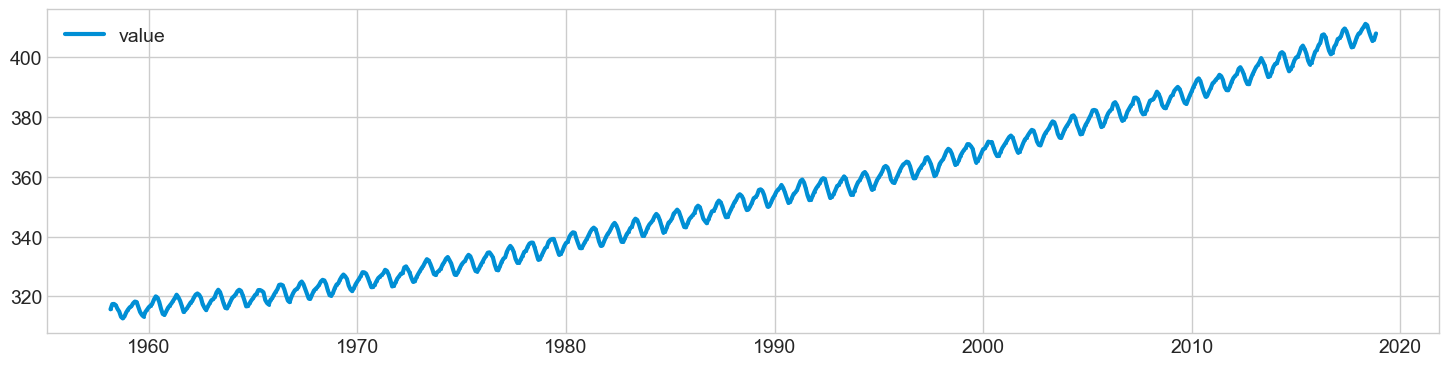

In [60]:
plot(df, ts_linewidth=3)

**Даны мають сезоннність та тренд, тому можна скористатись моделлю SARIMAX**

# Сorrection of detected anomalies

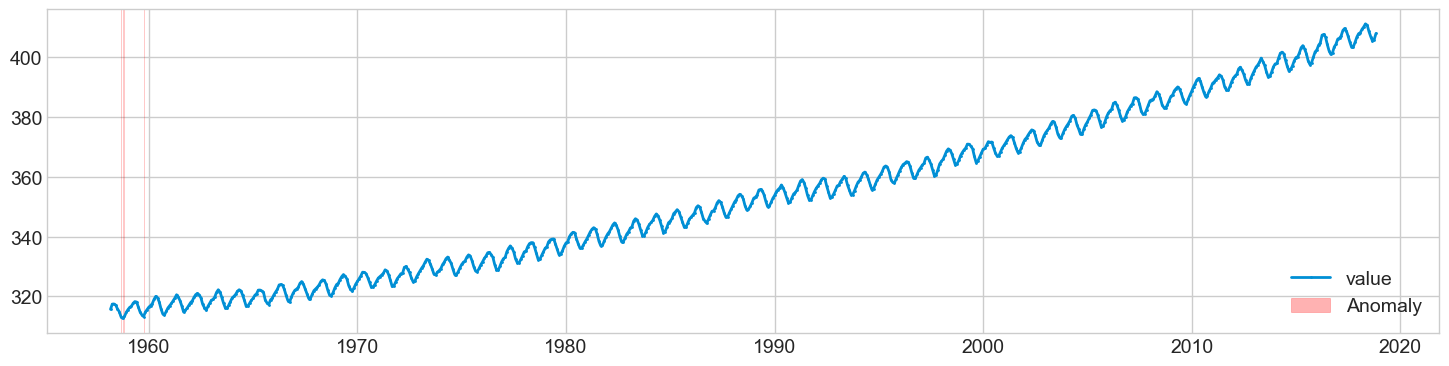

In [57]:
outlier_detector = OutlierDetector(LocalOutlierFactor())
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [58]:
anomalies[anomalies]

date
1958-09-01    True
1958-10-01    True
1958-11-01    True
1959-10-01    True
dtype: bool

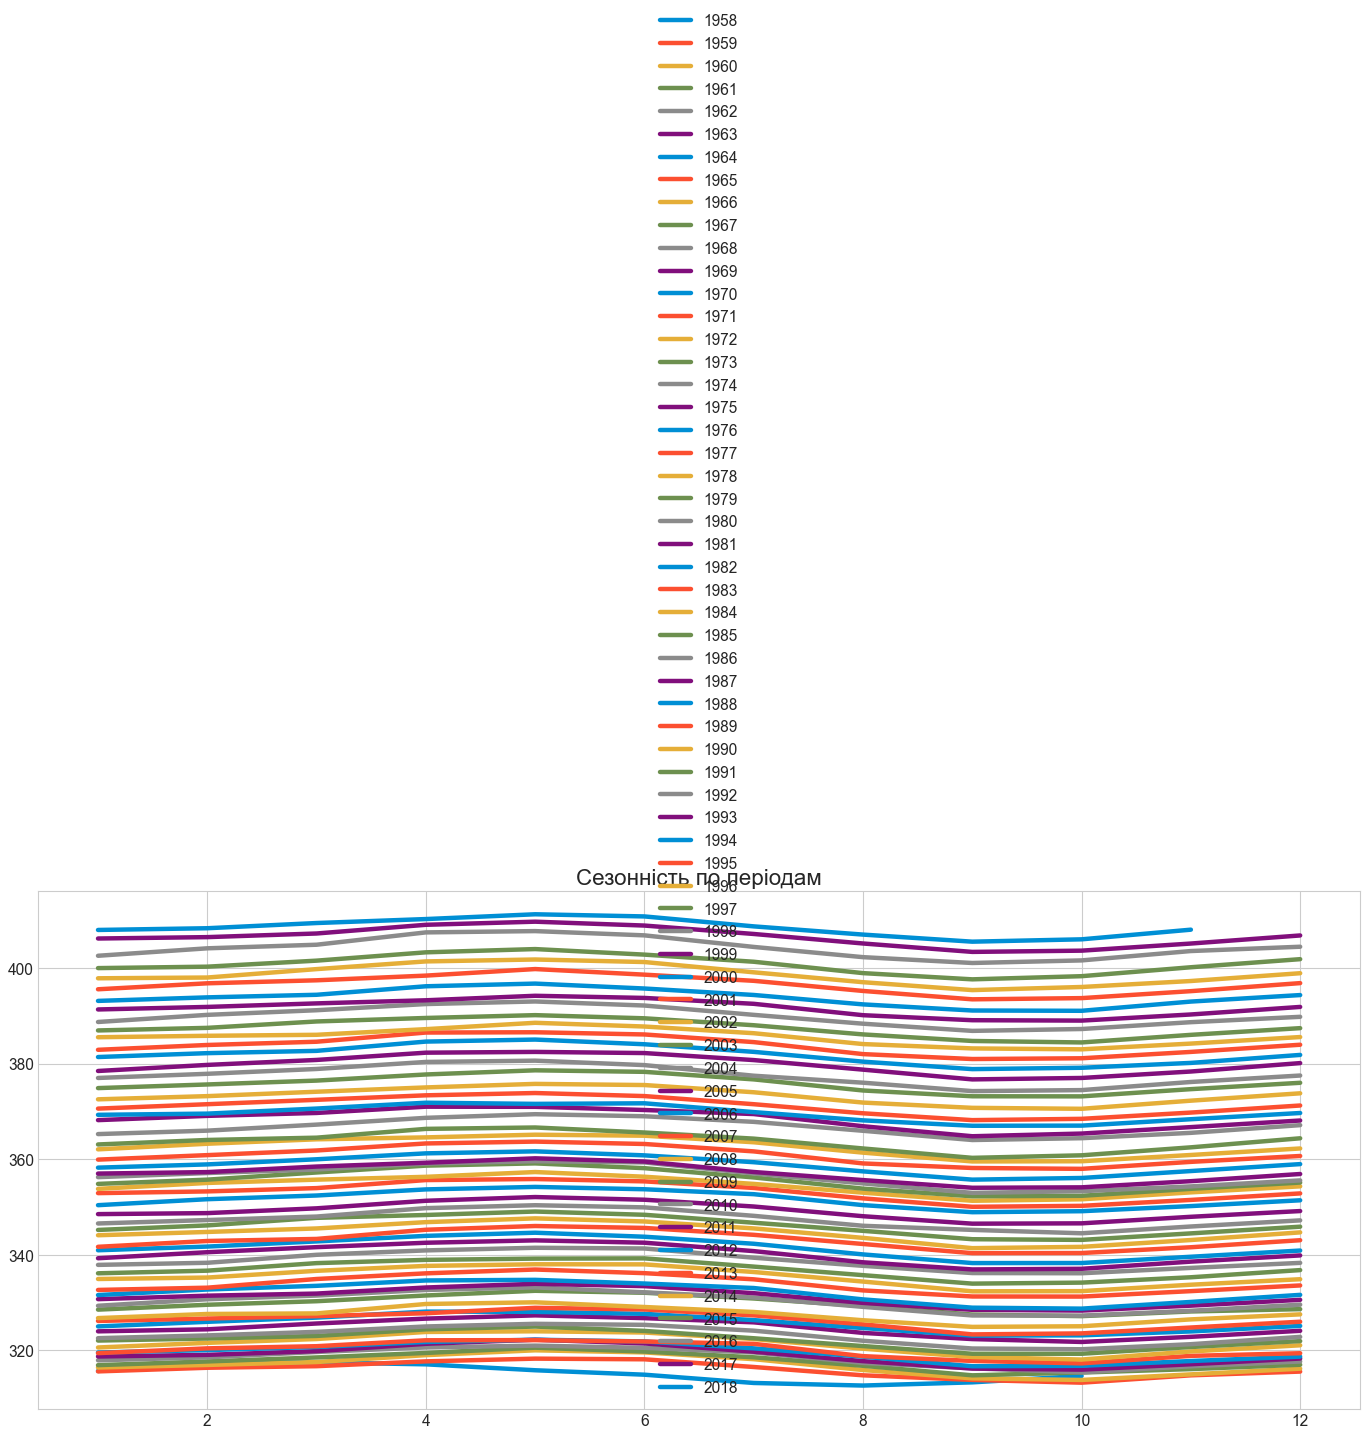

In [59]:
sesonal(df,12)

Text(0.5, 0.98, 'Мультиплікатива модель')

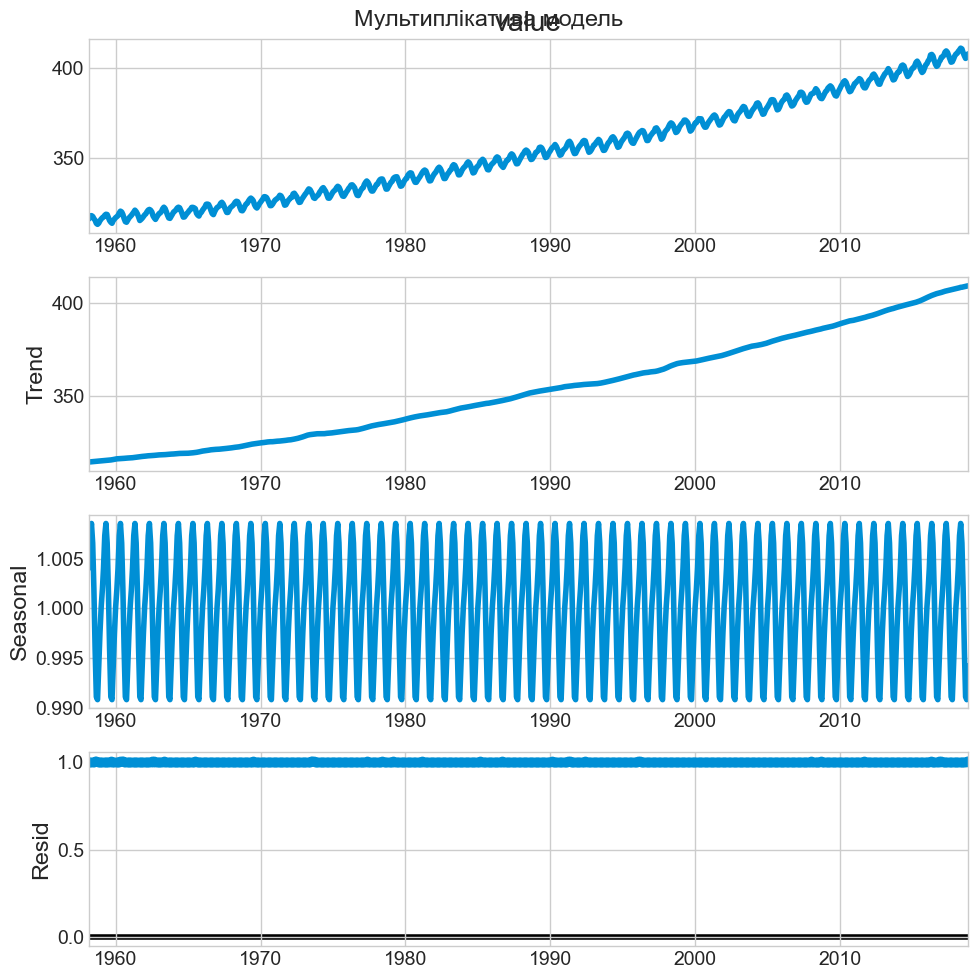

In [61]:
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)

plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

In [62]:
df.loc['1958-09-01']=df.loc['1959-09-01']
df.loc['1958-10-01']=df.loc['1960-10-01']
df.loc['1958-11-01']=df.loc['1959-11-01']
df.loc['1959-10-01']=df.loc['1960-10-01']

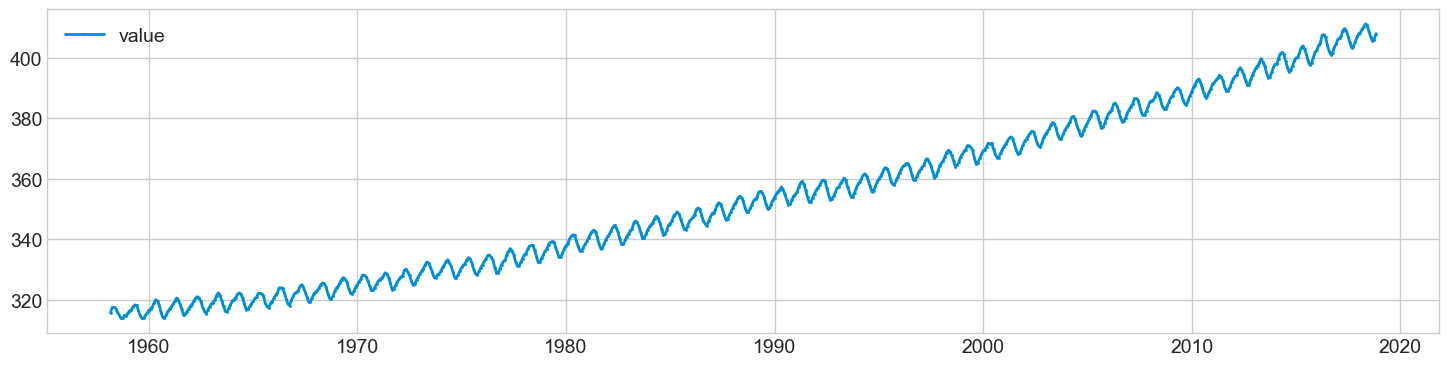

In [63]:
outlier_detector = OutlierDetector(LocalOutlierFactor())
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

# SARIMAX

In [43]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 

In [44]:
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10617.39832828139
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10457.37821691679
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2822.10872847603
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2377.959623194228
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1521.8785288720615
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1516.9589115212855
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1864.338786334426
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1357.4062887770606
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:9604.771834147039
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8519.191592455343
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2101.364214527621
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1884.326154086451
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1147.671724920887
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1140.5839273420565
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1582.5491836408755
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1055.3559188348256
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2371.0019758047247
SARIMAX(0, 1, 0)x(0, 0, 1

In [65]:
mod = sm.tsa.statespace.SARIMAX(df, 
                                order=(1, 1, 1), 
                                seasonal_order=(1, 1, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)
results = mod.fit()

In [66]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1888      0.085      2.234      0.026       0.023       0.354
ma.L1         -0.5468      0.073     -7.450      0.000      -0.691      -0.403
ar.S.L12       0.0029      0.014      0.211      0.833      -0.024       0.030
ma.S.L12      -0.8677      0.021    -40.607      0.000      -0.910      -0.826
sigma2         0.0943      0.005     20.305      0.000       0.085       0.103


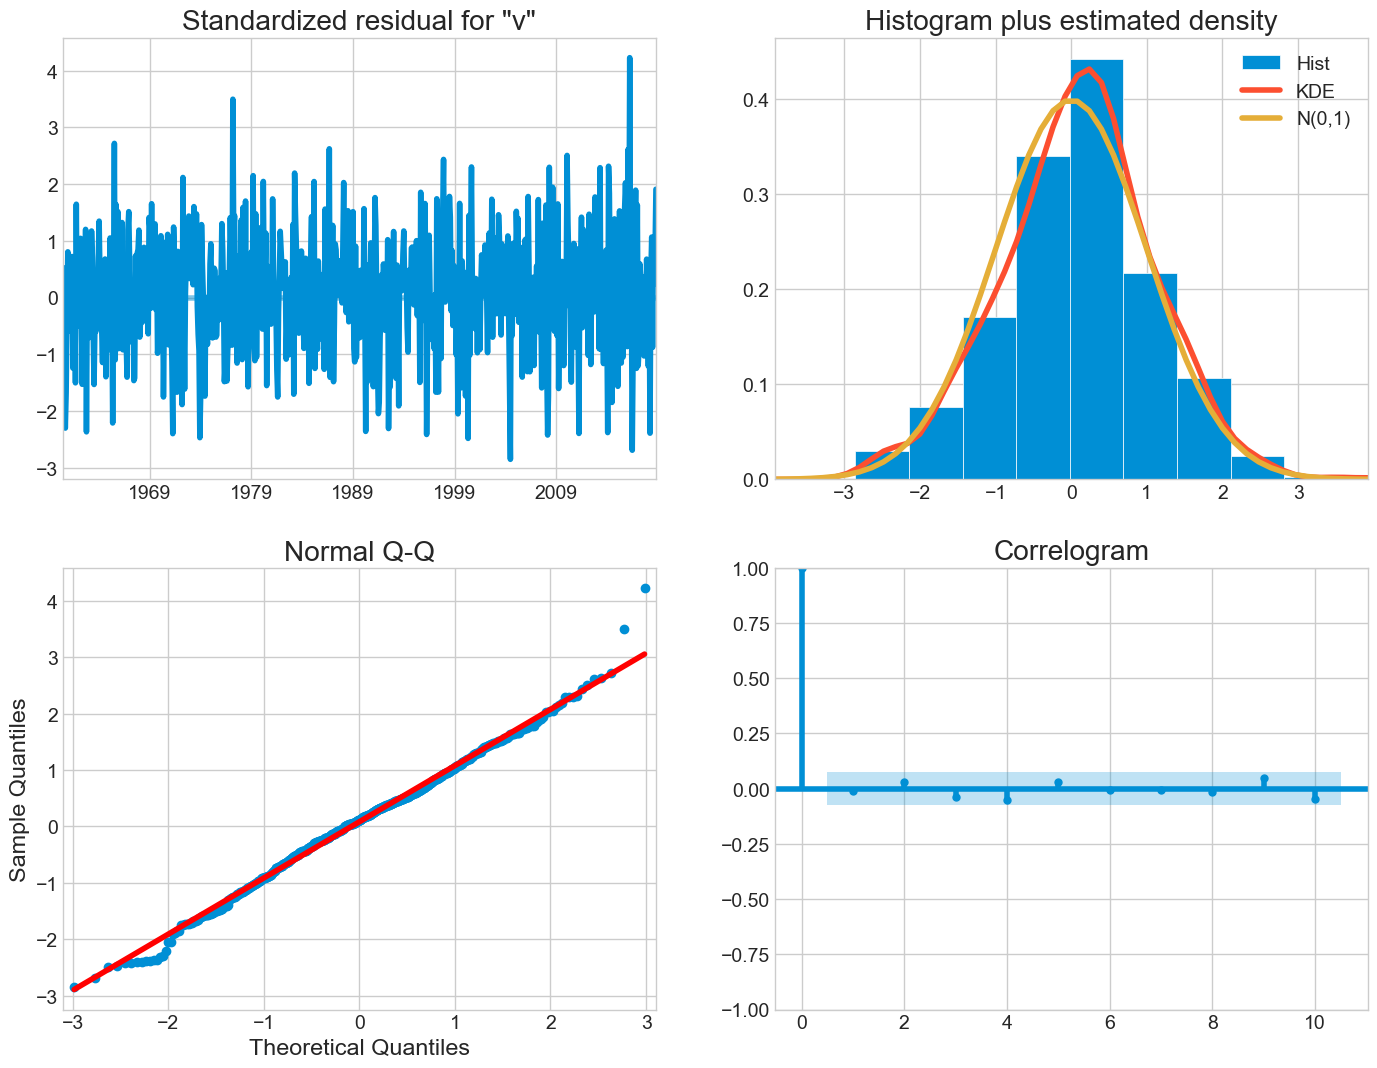

In [67]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [73]:
forecast = results.predict(start=0,end=1080, dynamic=False)

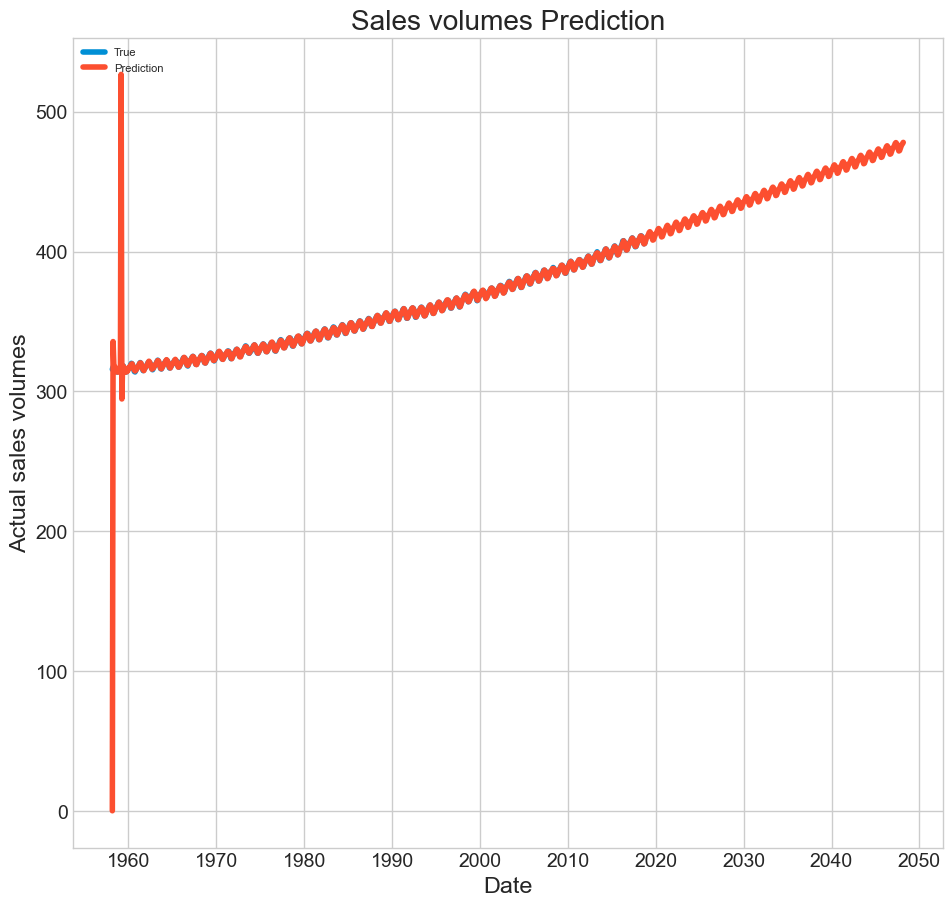

In [74]:
plt.plot(df, label='True')
plt.plot(forecast, label='Prediction')
plt.title('Sales volumes Prediction')
plt.xlabel('Date')
plt.ylabel('Actual sales volumes')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [76]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(df,forecast[:729]))
print("RMSE: ", rms)

RMSE:  14.088761534902945


In [91]:
pred_uc = results.get_forecast(steps=300)

pred_ci = pred_uc.conf_int()
pred_ci.head()

,lower value,upper value
2018-12-01,408.653393,409.857200
2019-01-01,409.693771,411.124281
2019-02-01,410.302082,411.890926
2019-03-01,411.163580,412.890276
2019-04-01,412.559560,414.412833


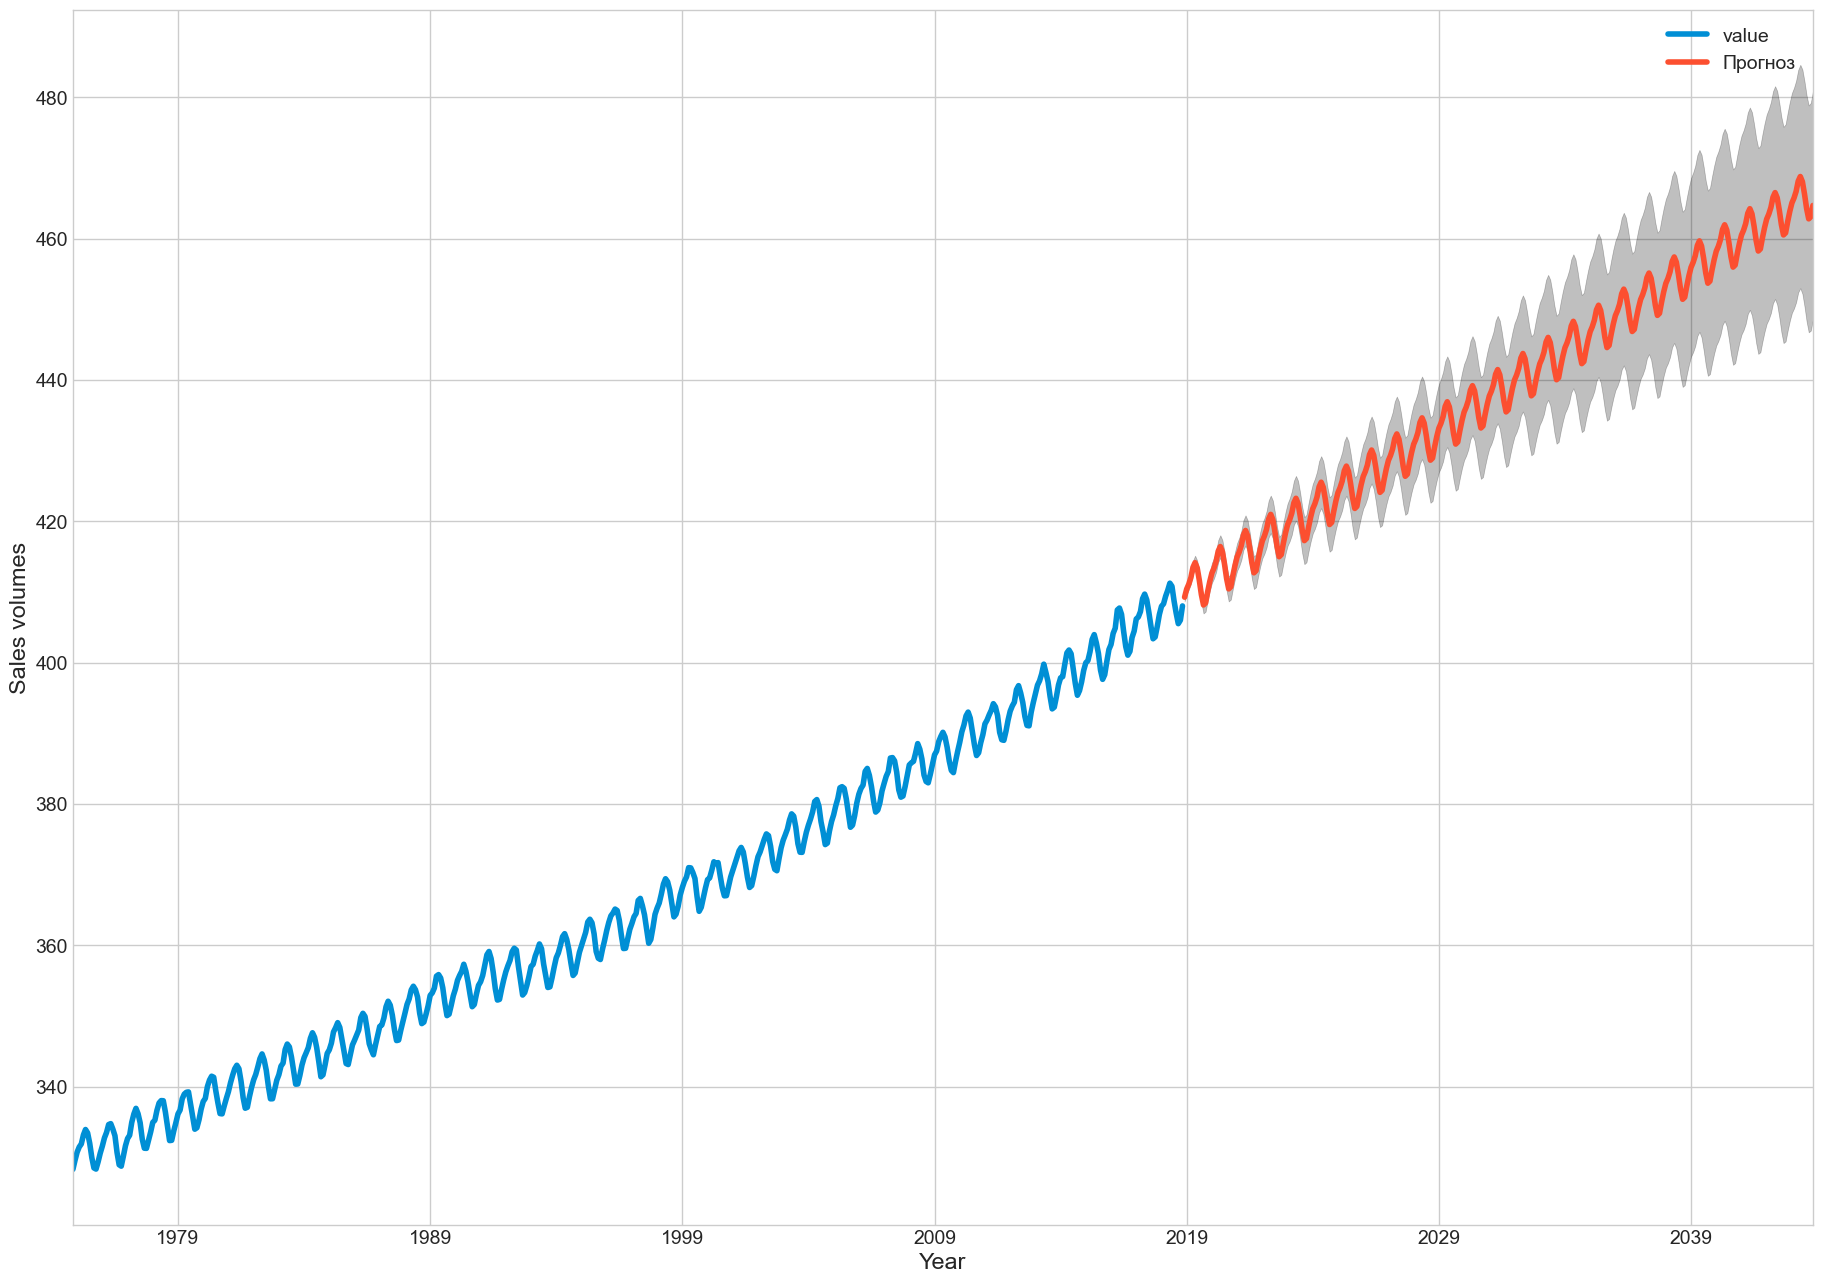

In [92]:
ax = df[200:].plot(label='Відомі', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Sales volumes')
plt.legend()
plt.show()

In [110]:
pred = pd.DataFrame(pred_uc.predicted_mean)
prediction = pd.concat([forecast], axis=1)
prediction = prediction[-352:]
prediction.to_csv('prediction30year.csv')
prediction.head()

,predicted_mean
2018-12-01,409.255297
2019-01-01,410.409026
2019-02-01,411.096504
2019-03-01,412.026928
2019-04-01,413.486197
